In [31]:
#!/usr/bin/env python3
import tensorflow as tf

raw_dataset = tf.data.TFRecordDataset(["tfrecords/dichasus-0c53.tfrecords", "tfrecords/dichasus-0c54.tfrecords", "tfrecords/dichasus-0c55.tfrecords", "tfrecords/dichasus-0c56.tfrecords", "tfrecords/dichasus-0c57.tfrecords",  "tfrecords/dichasus-0c5a.tfrecords", "tfrecords/dichasus-0c5b.tfrecords", "tfrecords/dichasus-0c5c.tfrecords","tfrecords/dichasus-0c61.tfrecords","tfrecords/dichasus-0c60.tfrecords","tfrecords/dichasus-0c62.tfrecords","tfrecords/dichasus-0c63.tfrecords","tfrecords/dichasus-0c64.tfrecords","tfrecords/dichasus-0c5e.tfrecords","tfrecords/dichasus-0c5f.tfrecords"])

feature_description = {
	"cfo": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"csi": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"pos-gnss": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"snr": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"stddev-gnss": tf.io.FixedLenFeature([], tf.string, default_value = ''),
	"time": tf.io.FixedLenFeature([], tf.float32, default_value = 0),
}
			
def record_parse_function(proto):
	record = tf.io.parse_single_example(proto, feature_description)

	# Measured carrier frequency offset between MOBTX and each receive antenna.
	cfo = tf.ensure_shape(tf.io.parse_tensor(record["cfo"], out_type = tf.float32), (32))

	# Channel coefficients for all antennas, over all subcarriers, real and imaginary parts
	csi = tf.ensure_shape(tf.io.parse_tensor(record["csi"], out_type = tf.float32), (32, 1024, 2))

	# Position of transmitter determined by GNSS, in latitude / longitude / height above sea level
	pos_gnss = tf.ensure_shape(tf.io.parse_tensor(record["pos-gnss"], out_type = tf.float64), (3))

	# Signal-to-Noise ratio estimates for all antennas
	snr = tf.ensure_shape(tf.io.parse_tensor(record["snr"], out_type = tf.float32), (32))

	# Standard deviation of position label estimate, in meters
	stddev_gnss = tf.ensure_shape(tf.io.parse_tensor(record["stddev-gnss"], out_type = tf.float32), (3))

	# Timestamp since start of measurement campaign, in seconds
	time = tf.ensure_shape(record["time"], ())

	return cfo, csi, pos_gnss, snr, stddev_gnss, time
			
dataset = raw_dataset.map(record_parse_function, num_parallel_calls = tf.data.experimental.AUTOTUNE)

# Optional: Cache dataset in RAM for faster training
dataset = dataset.cache()

In [32]:
for x in dataset:
    print("CFO:", x[0].numpy())
    print("CSI shape:", x[1].numpy())
    print("Position (GNSS):", x[2].numpy())
    print("SNR:", x[3].numpy())
    print("Standard Deviation (GNSS):", x[4].numpy())
    print("Time:", x[5].numpy())
    break

CFO: [-4632.0566 -4631.567  -4632.1196 -4631.7314 -4632.234  -4632.0137
 -4631.9634 -4631.958  -4631.5864 -4631.1816 -4631.9927 -4632.1597
 -4631.786  -4631.871  -4631.469  -4631.995  -4631.52   -4631.833
 -4632.364  -4632.416  -4632.187  -4632.4146 -4632.128  -4631.4185
 -4631.8022 -4631.965  -4632.314  -4632.5044 -4631.526  -4632.322
 -4632.0366 -4631.293 ]
CSI shape: [[[ 5.6399713  -6.931026  ]
  [ 4.9482403  -8.735823  ]
  [ 4.873475   -8.790683  ]
  ...
  [ 5.4559193  -8.337001  ]
  [ 5.279366   -8.433397  ]
  [ 5.2521563  -8.618498  ]]

 [[ 1.4930754  -5.2728157 ]
  [ 0.77296484 -6.3355837 ]
  [ 0.7124284  -6.53321   ]
  ...
  [ 0.72692376 -5.4011807 ]
  [ 0.85261    -5.636557  ]
  [ 0.80516756 -5.8959317 ]]

 [[ 5.9676867  -6.0961647 ]
  [ 5.50199    -7.235725  ]
  [ 5.47825    -7.517386  ]
  ...
  [ 5.5188894  -7.6158457 ]
  [ 5.4832563  -7.401519  ]
  [ 5.4989686  -7.456097  ]]

 ...

 [[ 3.0504584  -7.006638  ]
  [ 2.0765758  -8.144694  ]
  [ 2.0942895  -8.064124  ]
  ...
  [

2025-07-04 16:40:30.579020: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [33]:
ground_truth = dataset.map(lambda cfo, csi, pos_gnss, snr, stddev_gnss, time: pos_gnss)

In [34]:
csi = dataset.map(lambda cfo, csi, pos_gnss, snr, stddev_gnss, time: csi)

In [35]:
csi._shape_invariant_to_type_spec

<bound method CompositeTensor._shape_invariant_to_type_spec of <_MapDataset element_spec=TensorSpec(shape=(32, 1024, 2), dtype=tf.float32, name=None)>>

In [36]:
for x in ground_truth:
    print("Ground Truth Position (GNSS):", x.numpy())
    break

Ground Truth Position (GNSS): [ 48.74697224   9.10536916 516.51870441]


2025-07-04 16:40:33.817715: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
# making the dataset into a numpy array
import numpy as np

def dataset_to_numpy(dataset):
    numpy_arrays = []
    for x in dataset:
        numpy_arrays.append(x.numpy())
    return np.array(numpy_arrays)
ground_truth_np = dataset_to_numpy(ground_truth)

In [38]:
ground_truth_np.shape

(25595, 3)

In [39]:
csi_np = dataset_to_numpy(csi)

In [40]:
csi_np.shape

(25595, 32, 1024, 2)

In [45]:
csi_real= csi_np[:, :, :,0]
csi_imag = csi_np[:, :, :,1]

In [46]:
csi_real.shape, csi_imag.shape

((25595, 32, 1024), (25595, 32, 1024))

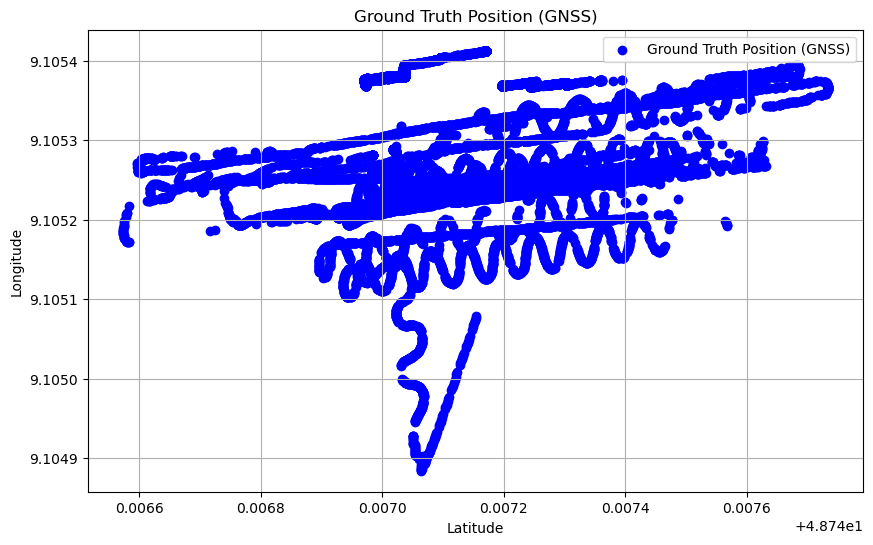

In [41]:
import matplotlib.pyplot as plt

# Plotting the ground truth positions
plt.figure(figsize=(10, 6))
plt.scatter(ground_truth_np[:, 0], ground_truth_np[:, 1], c='blue', label='Ground Truth Position (GNSS)')
plt.title('Ground Truth Position (GNSS)')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.grid()
plt.show()

In [42]:
import numpy as np
from scipy.special import softmax

def build_grid(grid_size=30, space_bounds=None):
    (xmin, xmax), (ymin, ymax) = space_bounds
    x_lin = np.linspace(xmin, xmax, grid_size)
    y_lin = np.linspace(ymin, ymax, grid_size)
        
    xv, yv = np.meshgrid(x_lin, y_lin)
    grid_points = np.stack([xv.ravel(), yv.ravel()], axis=1)
    return grid_points

def compute_soft_probability_maps(positions, grid_points, temperature=.1):
    N = positions.shape[0]
    K = grid_points.shape[0]
    dists = np.linalg.norm(positions[:, np.newaxis, :] - grid_points[np.newaxis, :, :], axis=2)
    sim_scores = -dists / temperature
    prob_maps = softmax(sim_scores, axis=1)
    return prob_maps

def estimate_positions_from_maps(prob_maps, grid_points):
    return np.matmul(prob_maps, grid_points)

def generate_all_probability_maps(positions, grid_size=30, temperature=.1):
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    print("Position bounds:", (x_min, x_max), (y_min, y_max))
    grid_points = build_grid(grid_size, space_bounds=((x_min, x_max), (y_min, y_max)))
    print("Grid points shape:", grid_points.shape)
    prob_maps = compute_soft_probability_maps(positions, grid_points, temperature=temperature)

    est_locations = estimate_positions_from_maps(prob_maps, grid_points)

    return prob_maps, est_locations, grid_points